# Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
SEED = 100

## Load amazon review dataset

In [3]:
products = pd.read_csv('amazon_baby_subset.csv')
products

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1
...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1


## Extract word counts and sentiments

As in the first assignment of this course, we compute the word counts for individual words and extract positive and negative sentiments from ratings. To summarize, we perform the following:

1. Remove punctuation.
2. Remove reviews with "neutral" sentiment (rating 3).
3. Set reviews with rating 4 or more to be positive and those with 2 or less to be negative.

In [4]:
# add an empty column to dataframe using assign
products['word_count'] = ''

for i in range(len(products)):
    d = {}
    
    if pd.isna(products['review'][i]):
        products["word_count"][i] = d
    else:
        word_list = [word.strip(",.") for word in products['review'][i].lower().split()]
        for word in word_list:
            if word not in d:
                d[word] = 1
            d[word] += 1
        products["word_count"][i] = d

products

C:\Users\vanch\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\vanch\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,review,rating,sentiment,word_count
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,"{'all': 3, 'of': 2, 'my': 2, 'kids': 3, 'have'..."
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,"{'we': 3, 'wanted': 3, 'to': 3, 'get': 2, 'som..."
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,"{'my': 2, 'daughter': 2, 'had': 2, 'her': 4, '..."
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,"{'one': 2, 'of': 2, 'baby's': 2, 'first': 2, '..."
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,"{'very': 2, 'cute': 2, 'interactive': 2, 'book..."
...,...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1,"{'my': 3, 'infant': 2, 'goes': 2, 'to': 4, 'a'..."
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1,"{'pretty': 2, 'please': 2, 'open': 2, 'and': 3..."
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1,"{'great': 2, '5-star': 3, 'product': 9, 'but':..."
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1,"{'when': 3, 'i': 4, 'received': 2, 'the': 13, ..."


In [5]:
def countawesome (word_count):
    count = 0
    if 'awesome' in word_count:
        count = word_count['awesome']
    return count

def countgreat (word_count):
    count = 0
    if 'great' in word_count:
        count = word_count['great']
    return count

def countfantastic (word_count):
    count = 0
    if 'fantastic' in word_count:
        count = word_count['fantastic']
    return count

def countamazing (word_count):
    count = 0
    if 'amazing' in word_count:
        count = word_count['amazing']
    return count

def countlove (word_count):
    count = 0
    if 'love' in word_count:
        count = word_count['love']
    return count

def counthorrible (word_count):
    count = 0
    if 'horrible' in word_count:
        count = word_count['horrible']
    return count

def countbad (word_count):
    count = 0
    if 'bad' in word_count:
        count = word_count['bad']
    return count

def countterrible (word_count):
    count = 0
    if 'terrible' in word_count:
        count = word_count['terrible']
    return count

def countawful (word_count):
    count = 0
    if 'awful' in word_count:
        count = word_count['awful']
    return count

def countwow (word_count):
    count = 0
    if 'wow' in word_count:
        count = word_count['wow']
    return count

def counthate (word_count):
    count = 0
    if 'hate' in word_count:
        count = word_count['hate']
    return count

In [6]:
# 1 Use .apply() to build a new feature with the counts for each of the selected_words
products['awesome'] = products['word_count'].apply(countawesome)
products['great'] = products['word_count'].apply(countgreat)
products['fantastic'] = products['word_count'].apply(countfantastic)
products['amazing'] = products['word_count'].apply(countamazing)
products['love'] = products['word_count'].apply(countlove)
products['horrible'] = products['word_count'].apply(counthorrible)
products['bad'] = products['word_count'].apply(countbad)
products['terrible'] = products['word_count'].apply(countterrible)
products['awful'] = products['word_count'].apply(countawful)
products['wow'] = products['word_count'].apply(countwow)
products['hate'] = products['word_count'].apply(counthate)

products

,name,review,rating,sentiment,word_count,awesome,great,fantastic,amazing,love,horrible,bad,terrible,awful,wow,hate
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,"{'all': 3, 'of': 2, 'my': 2, 'kids': 3, 'have'...",0,2,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,"{'we': 3, 'wanted': 3, 'to': 3, 'get': 2, 'som...",0,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,"{'my': 2, 'daughter': 2, 'had': 2, 'her': 4, '...",0,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,"{'one': 2, 'of': 2, 'baby's': 2, 'first': 2, '...",0,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,"{'very': 2, 'cute': 2, 'interactive': 2, 'book...",0,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1,"{'my': 3, 'infant': 2, 'goes': 2, 'to': 4, 'a'...",0,0,0,0,0,0,0,0,0,0,0
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1,"{'pretty': 2, 'please': 2, 'open': 2, 'and': 3...",0,0,0,0,0,0,0,0,0,0,0
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1,"{'great': 2, '5-star': 3, 'product': 9, 'but':...",0,2,0,0,0,0,0,0,0,0,0
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1,"{'when': 3, 'i': 4, 'received': 2, 'the': 13, ...",0,0,0,0,0,0,0,0,0,0,0


## Split data into training and test sets

In [7]:
train_data, test_data = train_test_split(products, train_size=.8, random_state=SEED)

## Train a logistic regression classifier

We will now train a logistic regression classifier with **sentiment** as the target and **word_count** as the features. We will set `validation_set=None` to make sure everyone gets exactly the same results.  

Remember, even though we now know how to implement logistic regression, we will use Turi Create for its efficiency at processing this Amazon dataset in its entirety.  The focus of this assignment is instead on the topic of precision and recall.

In [8]:
from sklearn.linear_model import LogisticRegression


# 2.  Create a new sentiment analysis model using only the selected_words as features
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate']

In [9]:
clf = LogisticRegression().fit(train_data[selected_words], train_data['sentiment'])

## Baseline: Majority class prediction

Recall from an earlier assignment that we used the **majority class classifier** as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points. 

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [10]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.4943947244465379


## Model Evaluation

In [12]:
y_pred = clf.predict(test_data[selected_words])
    
f1_test = f1_score(test_data['sentiment'], y_pred)
precision_test = precision_score(test_data['sentiment'], y_pred)
recall_test = recall_score(test_data['sentiment'], y_pred)
accuracy_test = accuracy_score(test_data['sentiment'], y_pred)

print("Model Evaluation Metrics Using Untouched Test Dataset")
print("*****************************************************")
print("F1 Score:  "+"{:.2f}".format(f1_test))
print("Precision: "+"{:.2f}".format(precision_test))
print("Recall: "+"{:.2f}".format(recall_test))
print("Accuracy:  "+"{:.2f}".format(accuracy_test))
print("*****************************************************")
print("Confusion Metrix:\n",confusion_matrix(test_data['sentiment'], y_pred))
print("*****************************************************")

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
F1 Score:  0.56
Precision: 0.74
Recall: 0.45
Accuracy:  0.65
*****************************************************
Confusion Metrix:
 [[4533  834]
 [2884 2364]]
*****************************************************


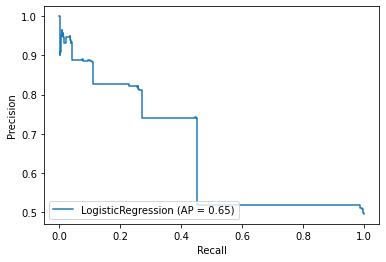

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(clf, test_data[selected_words], test_data['sentiment'])